In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Ensures that the display width isn't restricted
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 0 if x=='normal' else 1)
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [4]:
# land, wrongfragment,urgent, numfailedlogins,loggedin,rootshell,suattempted,numshells,ishostlogin,isguestlogin
df['land'] = df['land'].astype('category')
df['wrongfragment'] = df['wrongfragment'].astype('category')
df['urgent'] = df['urgent'].astype('category')
#df['numfailedlogins'] = df['numfailedlogins'].astype('category')
df['loggedin'] = df['loggedin'].astype('category')
df['rootshell'] = df['rootshell'].astype('category')
df['suattempted'] = df['suattempted'].astype('category')
df['numshells'] = df['numshells'].astype('category')
df['ishostlogin'] = df['ishostlogin'].astype('category')
df['isguestlogin'] = df['isguestlogin'].astype('category')

In [5]:
# Host count of flags
df['serror'] = df['count']*df['serrorrate']
df['rerror'] = df['count']*df['rerrorrate']

# Host srv count of flags
df['srvserror'] = df['srvcount']*df['srvrerrorrate']
df['srvrerror'] = df['srvcount']*df['srvserrorrate']

df['samesrv'] = df['count']*df['samesrvrate']
df['diffsrv'] = df['count']*df['diffsrvrate']

# Host count of flags
df['dsthostserror'] = df['dsthostcount']*df['dsthostserrorrate']
df['dsthostrerror'] = df['dsthostcount']*df['dsthostrerrorrate']

# Host srv count of flags
df['dsthostsrvserror'] = df['dsthostsrvcount']*df['dsthostsrvrerrorrate']
df['dsthostsrvrerror'] = df['dsthostsrvcount']*df['dsthostsrvserrorrate']

df['dsthostsamesrv'] = df['dsthostsrvcount']*df['dsthostsamesrvrate']
df['dsthostdiffsrv'] = df['dsthostsrvcount']*df['dsthostdiffsrvrate']

In [6]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
all_attacks = df['attack'].unique()

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks:
    category_data = df[df['attack'] == category]

    if len(category_data) > 30:
        category_train, category_test = train_test_split(category_data, test_size=0.2,random_state=42)

    elif len(category_data) == 1:
        train_data = pd.concat([train_data,category_data])
        continue

    elif len(category_data) > 1 and len(category_data) <= 5:
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,1)
        test_selection = category_data[~category_data.index.isin(chooser)]
        train_selection = category_data[category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])
        continue
    
    elif len(category_data) > 5 and len(category_data) <= 10:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,3)
        test_selection = category_data[category_data.index.isin(chooser)]
        train_selection = category_data[~category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])
        continue
    

    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)
    
    # Append to the train and test sets
    train_data = pd.concat([train_data,category_train])
    test_data = pd.concat([test_data,category_test])

In [7]:
X_train = train_data.drop(['attack','is_attack'],axis=1)
y_train = train_data['is_attack']
X_test = test_data.drop(['attack','is_attack'],axis=1)
y_test = test_data['is_attack']

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag','land','wrongfragment','urgent','loggedin','rootshell','suattempted','numshells',
                       'ishostlogin','isguestlogin']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [9]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42,class_weight='balanced',n_estimators=100,
                            min_samples_split= 7,
                            max_features= 'sqrt',
                            max_depth= 30)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

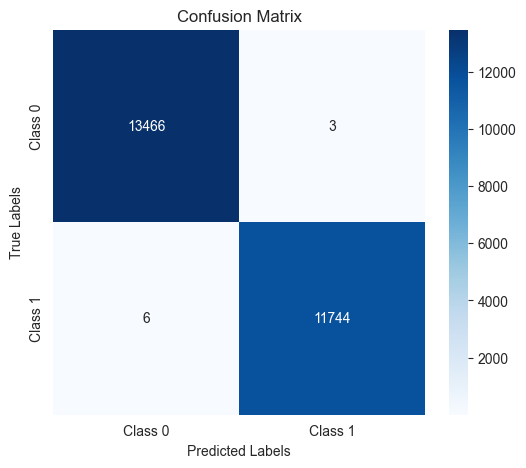

In [11]:
from sklearn.metrics import confusion_matrix


cmrf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cmrf, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
y_pred_df = pd.DataFrame(y_pred_rf,index=y_test.index)
y_pred_df.isna().sum()

0    0
dtype: int64

In [13]:
combined_pred = pd.concat([y_test,y_pred_df],axis=1)
combined_pred.columns = ['is_attack','is_attack_pred']
predicted_probabilities = rf.predict_proba(X_test)
combined_pred['predict_prob'] = predicted_probabilities[:, 1]
combined_pred.head()

,is_attack,is_attack_pred,predict_prob
18091,0,0,0.0
29741,0,0,0.0
76709,0,0,0.0
91928,0,0,0.0
39962,0,0,0.0


In [14]:
combined_pred_eq = combined_pred[combined_pred['is_attack'] == combined_pred['is_attack_pred']]
combined_pred_uneq = combined_pred[combined_pred['is_attack'] != combined_pred['is_attack_pred']]
combined_pred_uneq = combined_pred_uneq[combined_pred_uneq['is_attack'] == 1]
combined_pred = pd.concat([combined_pred_eq,combined_pred_uneq],axis=0)
combined_pred.shape

(25216, 3)

In [15]:
op = pd.merge(X_test,combined_pred[['is_attack','is_attack_pred']],left_index=True,right_index=True)
op = pd.merge(op,df[['attack']],left_index=True,right_index=True)
op.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,is_attack,is_attack_pred,attack
18091,-0.109310,2.223211,-1.176110,0.751252,-0.007738,-0.005282,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.182970,2.168276,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.349280,-0.336057,0.736054,1.258277,1.066418,-0.438899,-0.479531,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,-0.657260,-0.540987,-0.251742,-0.242121,-0.503694,1.161659,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,1.304684,-0.292247,0,0,normal
29741,-0.109310,-0.124696,-0.442321,0.751252,-0.007699,-0.002285,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,1.233669,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.585910,-0.148039,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.349280,-0.374565,0.736054,1.258277,1.066418,-0.438899,-0.479531,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,0.654638,-0.540987,-0.251742,-0.242121,-0.503694,-0.099836,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,1.304684,-0.292247,0,0,normal
76709,-0.109310,2.223211,-1.176110,0.751252,-0.007741,-0.005290,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.725707,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.349280,-0.374565,-1.378981,0.734386,1.066418,-0.438899,2.765688,-0.199837,-0.639313,-0.624805,-0.387837,-0.376431,0.654638,-0.540987,-0.251742,-0.242121,-0.503694,-0.329199,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,0.800655,-0.292247,0,0,normal
91928,-0.109310,2.223211,1.086406,0.751252,-0.007729,-0.005277,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.673283,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,-1.185430,1.260395,-0.374565,0.736054,1.204081,1.021860,-0.385959,-0.479531,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,-0.657260,-0.540987,-0.251742,-0.242121,-0.503694,-0.329485,-0.155959,-0.625486,-0.343015,-0.173356,-0.418804,1.209266,0.212254,0,0,normal
39962,-0.098889,2.223211,-1.176110,0.751252,-0.007741,-0.005303,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.708232,-0.313490,-0.637521,-0.632055,-0.374383,-0.374543,-0.753233,3.369625,1.165770,-1.207764,-0.755994,-0.002991,-0.174195,-0.414627,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,0.654638,-0.540987,-0.251742,-0.242121,-0.503694,-0.329342,-0.156354,-0.625486,-0.343015,-0.173356,-0.418804,-0.766701,0.031930,0,0,normal


In [16]:
attacks = op[np.logical_or(op['is_attack_pred'] == 1,np.logical_or(op['is_attack_pred'] == 1,op['is_attack'] == 1))].copy()
attacks.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,is_attack,is_attack_pred,attack
25445,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.100384,-0.327278,1.601975,1.604940,-0.374383,-0.374543,-1.458396,-0.016244,-0.374565,0.736054,-1.008907,-1.116959,-0.068313,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,1.861644,-0.251742,-0.242121,0.157630,-0.283326,0.052797,1.655712,-0.343015,-0.173356,-0.020284,-0.910610,-0.235516,1,1,neptune
71233,-0.10931,-0.124696,1.453300,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.275129,-0.299703,1.601975,1.604940,-0.374383,-0.374543,-1.435649,-0.016244,-0.374565,0.736054,-0.873418,-1.005562,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,2.090466,-0.251742,-0.242121,0.488292,-0.244621,0.076497,1.655712,-0.343015,-0.173356,1.474165,-0.899748,-0.061271,1,1,neptune
30788,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.187757,-0.313490,-0.637521,-0.632055,2.746133,2.713628,-1.458396,0.039262,-0.374565,0.736054,-0.999874,-1.116959,-0.068313,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,3.211260,1.514881,-0.503694,-0.280459,0.108097,-0.625486,3.321361,0.002502,-0.418804,-0.910436,-0.221333,1,1,neptune
30951,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.174233,-0.368641,-0.637521,-0.632055,2.746133,2.713628,-1.481144,0.150274,-0.374565,0.736054,-1.036005,-1.161518,0.037568,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,1.385313,0.109279,-0.503694,-0.328625,-0.011192,-0.625486,3.321361,-0.138184,-0.418804,-0.911305,-0.274012,1,1,neptune
111798,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.934376,-0.285915,-0.637521,-0.632055,2.746133,2.713628,-1.412902,0.039262,-0.374565,0.736054,-0.981809,-1.094680,-0.015372,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,2.754773,2.217682,-0.503694,-0.234013,0.068005,-0.625486,3.321361,0.072845,-0.418804,-0.909480,-0.178785,1,1,neptune


In [17]:
augmented_train = X_train[X_train.index.isin(y_train[y_train==1].index)]
augmented_output = df[df.index.isin(y_train[y_train==1].index)]['attack']
augmented_attack = pd.merge(augmented_train,augmented_output,left_index=True,right_index=True)
augmented_attack.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,attack
76074,-0.10931,-0.124696,0.536064,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.790629,-0.175614,1.601975,1.604940,-0.374383,-0.374543,-1.390155,-0.016244,-0.374565,0.736054,-0.909548,-1.027842,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,2.765491,-0.251742,-0.242121,1.976270,-0.136391,0.146412,1.655712,-0.343015,-0.173356,1.075645,-0.903484,-0.109897,neptune
116621,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.252868,-0.285915,-0.637521,-0.632055,2.746133,2.713628,-1.367408,0.094768,-0.374565,0.736054,-0.981809,-1.094680,0.037568,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,1.526982,2.217682,-0.503694,-0.246341,-0.017512,-0.625486,3.321361,0.072845,-0.418804,-0.909480,-0.164602,neptune
71284,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.016962,-0.368641,1.601975,1.604940,-0.374383,-0.374543,-1.481144,0.094768,-0.374565,0.736054,-0.909548,-1.027842,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,0.442948,-0.251742,-0.242121,-0.338363,-0.331206,-0.060172,1.655712,-0.343015,-0.173356,1.075645,-0.903484,-0.109897,neptune
74957,-0.10931,-0.124696,0.169170,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.418877,-0.230765,1.601975,1.604940,-0.374383,-0.374543,-1.321913,-0.071750,-0.374565,0.736054,-0.945679,-1.072400,-0.174195,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,0.969238,-0.251742,-0.242121,1.314946,-0.192155,-0.065702,1.655712,-0.343015,-0.173356,0.677125,-0.907482,-0.180811,neptune
102313,-0.10931,-0.124696,1.759045,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.620859,-0.272127,1.601975,1.604940,-0.374383,-0.374543,-0.093563,0.483310,-0.374565,0.736054,-0.503081,-0.626813,-0.333018,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,-0.657260,-0.392253,-0.251742,-0.242121,0.818954,-0.227992,-0.157539,1.655712,-0.343015,-0.173356,5.558992,-0.786167,-0.049114,neptune


In [18]:
tst = attacks.drop(['is_attack_pred','is_attack'],axis=1)

In [19]:
tst = pd.concat([tst,augmented_attack],axis=0)
tst.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,attack
25445,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.100384,-0.327278,1.601975,1.604940,-0.374383,-0.374543,-1.458396,-0.016244,-0.374565,0.736054,-1.008907,-1.116959,-0.068313,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,1.861644,-0.251742,-0.242121,0.157630,-0.283326,0.052797,1.655712,-0.343015,-0.173356,-0.020284,-0.910610,-0.235516,neptune
71233,-0.10931,-0.124696,1.453300,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.275129,-0.299703,1.601975,1.604940,-0.374383,-0.374543,-1.435649,-0.016244,-0.374565,0.736054,-0.873418,-1.005562,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,2.090466,-0.251742,-0.242121,0.488292,-0.244621,0.076497,1.655712,-0.343015,-0.173356,1.474165,-0.899748,-0.061271,neptune
30788,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.187757,-0.313490,-0.637521,-0.632055,2.746133,2.713628,-1.458396,0.039262,-0.374565,0.736054,-0.999874,-1.116959,-0.068313,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,3.211260,1.514881,-0.503694,-0.280459,0.108097,-0.625486,3.321361,0.002502,-0.418804,-0.910436,-0.221333,neptune
30951,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.174233,-0.368641,-0.637521,-0.632055,2.746133,2.713628,-1.481144,0.150274,-0.374565,0.736054,-1.036005,-1.161518,0.037568,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,1.385313,0.109279,-0.503694,-0.328625,-0.011192,-0.625486,3.321361,-0.138184,-0.418804,-0.911305,-0.274012,neptune
111798,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.934376,-0.285915,-0.637521,-0.632055,2.746133,2.713628,-1.412902,0.039262,-0.374565,0.736054,-0.981809,-1.094680,-0.015372,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,2.754773,2.217682,-0.503694,-0.234013,0.068005,-0.625486,3.321361,0.072845,-0.418804,-0.909480,-0.178785,neptune


In [20]:
acount = attacks['attack'].value_counts().reset_index()
specials = set(acount[acount['count'] <= 3]['attack'])
specials

{'ftp_write', 'loadmodule', 'multihop', 'perl', 'phf', 'rootkit', 'spy'}

In [21]:
tst['nattack'] = tst['attack'].apply(lambda x: 'other' if x in specials else x)

In [22]:
all_attacks1 = tst['attack'].unique()

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train1_data = pd.DataFrame()
test1_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks1:
    # Get data for the current category
    category_data = tst[tst['attack'] == category]
    #print(category)
    # Split into train and test, ensuring each category appears in test
    if len(category_data) > 30:
        category_train, category_test = train_test_split(category_data, test_size=0.2,random_state=42)
    elif len(category_data) == 1:
        test1_data = pd.concat([test1_data,category_data])
        noise_data = category_data.copy()
        noise_data['count'] += 0.0001
        #display(category_data)
        #display(noise_data)
        train1_data = pd.concat([train1_data,noise_data],axis=0)
        # print(train1_data[train1_data['attack'] == category].shape)
        continue
    elif len(category_data) > 1 and len(category_data) <= 5:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,1)
        test_selection = category_data[~category_data.index.isin(chooser)]
        train_selection = category_data[category_data.index.isin(chooser)]

        test1_data = pd.concat([test1_data,test_selection])
        train1_data = pd.concat([train1_data,train_selection])

        noise_data = train_selection.copy()
        noise_data['count'] += 0.0001
        train1_data = pd.concat([train1_data,noise_data],axis=0)
        continue
    
    elif len(category_data) > 5 and len(category_data) <= 10:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,3)
        test_selection = category_data[category_data.index.isin(chooser)]
        train_selection = category_data[~category_data.index.isin(chooser)]

        test1_data = pd.concat([test1_data,test_selection])
        train1_data = pd.concat([train1_data,train_selection])
        continue
    

    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)
    
    # Append to the train and test sets
    train1_data = pd.concat([train1_data,category_train])
    test1_data = pd.concat([test1_data,category_test])

In [23]:
train1_data.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,attack,nattack
119182,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.869264,-0.106676,1.601975,1.60494,-0.374383,-0.374543,-1.344660,-0.016244,-0.374565,0.736054,-1.017940,-1.139238,-0.015372,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,2.868461,-0.251742,-0.242121,2.802925,-0.044502,0.157077,1.655712,-0.343015,-0.173356,-0.119914,-0.911045,-0.243621,neptune,neptune
21767,-0.10931,-0.124696,0.474915,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.074172,-0.327278,1.601975,1.60494,-0.374383,-0.374543,-1.458396,0.039262,-0.374565,0.736054,-0.900516,-1.027842,-0.174195,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,-0.657260,1.827321,-0.251742,-0.242121,0.157630,-0.284186,0.090125,1.655712,-0.343015,-0.173356,1.175275,-0.902963,-0.130159,neptune,neptune
7584,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.266392,-0.189402,1.601975,1.60494,-0.374383,-0.374543,-1.367408,-0.016244,-0.374565,0.736054,-0.927614,-1.050121,-0.068313,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,2.079025,-0.251742,-0.242121,1.810939,-0.146569,0.075312,1.655712,-0.343015,-0.173356,0.876385,-0.905657,-0.107871,neptune,neptune
93134,-0.10931,-0.124696,0.230319,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.379977,-0.230765,1.601975,1.60494,-0.374383,-0.374543,-1.390155,-0.071750,-0.374565,0.736054,-0.945679,-1.072400,-0.174195,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,2.227759,-0.251742,-0.242121,1.314946,-0.170078,0.042923,1.655712,-0.343015,-0.173356,0.677125,-0.907482,-0.180811,neptune,neptune
4252,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.161545,-0.161827,1.601975,1.60494,-0.374383,-0.374543,-1.344660,-0.016244,-0.374565,0.736054,-0.873418,-1.005562,-0.174195,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,1.941732,-0.251742,-0.242121,2.141601,-0.125783,0.061092,1.655712,-0.343015,-0.173356,1.474165,-0.899748,-0.099767,neptune,neptune


In [24]:
X1_train = train1_data.drop(['attack','nattack'],axis=1)
y1_train = train1_data['nattack']
X1_test = test1_data.drop(['attack','nattack'],axis=1)
y1_test = test1_data['nattack']

In [25]:
target_encoder = LabelEncoder()
y1_train_encoded = target_encoder.fit_transform(y1_train)
y1_test_encoded = target_encoder.transform(y1_test)

In [26]:
target_classes = [target_encoder.classes_[i] for i in range(len(target_encoder.classes_))]

In [27]:
rf2 = RandomForestClassifier(random_state=42,class_weight='balanced')
rf2.fit(X1_train,y1_train_encoded)
y_pred1 = rf2.predict(X1_test)

<Axes: >

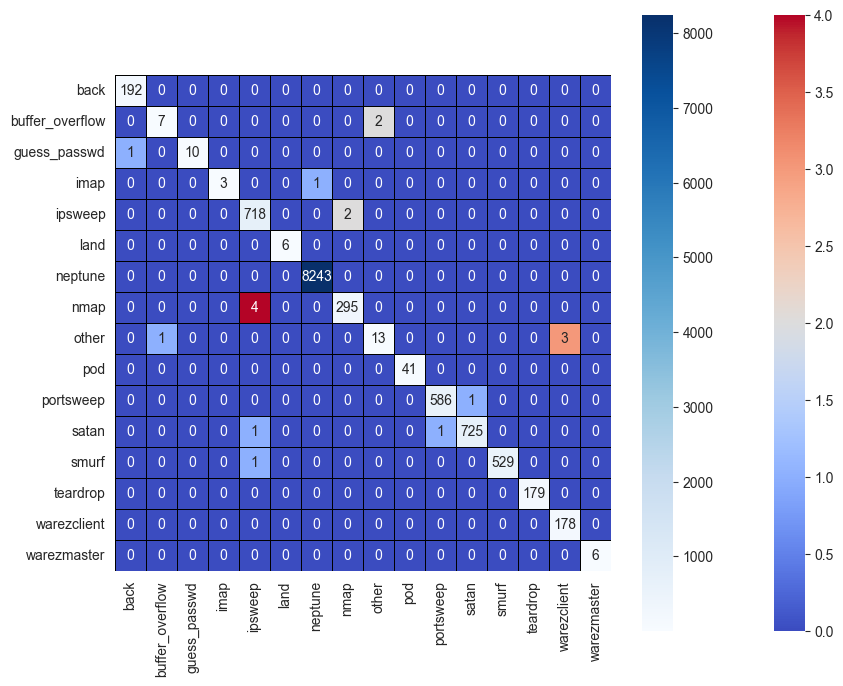

In [28]:
from sklearn.metrics import confusion_matrix

cmrf = confusion_matrix(y1_test_encoded, y_pred1)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmrf.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmrf, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmrf, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes) 

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y1_test_encoded, y_pred1,target_names=target_classes))

                 precision    recall  f1-score   support

           back       0.99      1.00      1.00       192
buffer_overflow       0.88      0.78      0.82         9
   guess_passwd       1.00      0.91      0.95        11
           imap       1.00      0.75      0.86         4
        ipsweep       0.99      1.00      0.99       720
           land       1.00      1.00      1.00         6
        neptune       1.00      1.00      1.00      8243
           nmap       0.99      0.99      0.99       299
          other       0.87      0.76      0.81        17
            pod       1.00      1.00      1.00        41
      portsweep       1.00      1.00      1.00       587
          satan       1.00      1.00      1.00       727
          smurf       1.00      1.00      1.00       530
       teardrop       1.00      1.00      1.00       179
    warezclient       0.98      1.00      0.99       178
    warezmaster       1.00      1.00      1.00         6

       accuracy              

In [30]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'n_estimators': [50,100, 150,200,300],
    'max_depth': [10, 20,30,40,50],
    'min_samples_split': [2, 5, 7,10],
    'max_features': ['sqrt', 'log2', None]
}


rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=500, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)
random_search.fit(X1_train, y1_train_encoded)
random_search.best_params_

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 300 is smaller than n_iter=500. Running 300 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 300,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 40}

<Axes: >

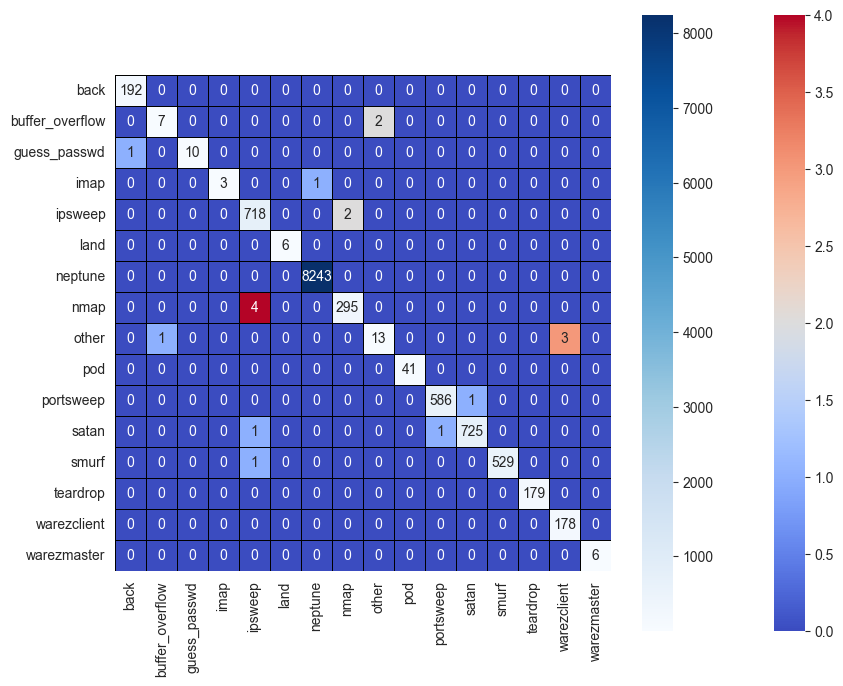

In [31]:
best_rf = random_search.best_estimator_
y_pred_rf_best = best_rf.predict(X1_test)
from sklearn.metrics import confusion_matrix

cmrf = confusion_matrix(y1_test_encoded, y_pred1)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmrf.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmrf, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmrf, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes) 

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y1_test_encoded, y_pred_rf_best,target_names=target_classes))

                 precision    recall  f1-score   support

           back       0.99      1.00      1.00       192
buffer_overflow       0.78      0.78      0.78         9
   guess_passwd       1.00      0.91      0.95        11
           imap       1.00      0.75      0.86         4
        ipsweep       1.00      1.00      1.00       720
           land       1.00      1.00      1.00         6
        neptune       1.00      1.00      1.00      8243
           nmap       1.00      0.99      1.00       299
          other       0.86      0.71      0.77        17
            pod       0.98      1.00      0.99        41
      portsweep       1.00      1.00      1.00       587
          satan       1.00      1.00      1.00       727
          smurf       1.00      1.00      1.00       530
       teardrop       1.00      1.00      1.00       179
    warezclient       0.98      1.00      0.99       178
    warezmaster       1.00      1.00      1.00         6

       accuracy              

In [33]:
y1_pred_df = pd.DataFrame(y_pred_rf_best,index=y1_test.index)
y1_pred_df.isna().sum()

0    0
dtype: int64

In [34]:
combined_pred1 = pd.concat([y1_test,y1_pred_df],axis=1)
combined_pred1.columns = ['nattack','nattack_pred']
predicted_probabilities1 = rf2.predict_proba(X1_test)
combined_pred1['predict_prob'] = predicted_probabilities1[:, 1]

In [35]:
ocategory = dict()
for i in range(len(target_encoder.classes_)):
    ocategory[i] = target_encoder.classes_[i]
ocategory

{0: 'back',
 1: 'buffer_overflow',
 2: 'guess_passwd',
 3: 'imap',
 4: 'ipsweep',
 5: 'land',
 6: 'neptune',
 7: 'nmap',
 8: 'other',
 9: 'pod',
 10: 'portsweep',
 11: 'satan',
 12: 'smurf',
 13: 'teardrop',
 14: 'warezclient',
 15: 'warezmaster'}

In [36]:
combined_pred1['nattack_pred'] = combined_pred1['nattack_pred'].map(ocategory)

In [37]:
odf_test = combined_pred1[combined_pred1['nattack'] == 'other'].copy()
odf_test.drop(['nattack','nattack_pred','predict_prob'],axis=1,inplace=True)
odf_test = pd.merge(odf_test,X1_test,left_index=True,right_index=True)
odf_test = pd.merge(odf_test,df['attack'],left_index=True,right_index=True)
odf_test.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,attack
77534,-0.109310,-0.124696,-0.686917,0.751252,-0.007638,-0.005310,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.725707,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.34928,-0.374565,-1.822131,-1.008907,1.066418,-0.438899,2.765688,4.148294,-0.639313,-0.624805,-0.387837,-0.376431,-1.969157,-0.540987,-0.251742,-0.242121,-0.503694,-0.329199,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,-0.876545,-0.292247,ftp_write
51170,-0.109310,-0.124696,-0.686917,0.751252,-0.007746,-0.005308,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,1.233669,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.725707,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.34928,-0.374565,-1.812059,-0.277266,1.066418,-0.438899,2.765688,-0.111100,-0.639313,-0.624805,-0.387837,-0.376431,-4.592953,-0.540987,-0.251742,-0.242121,-0.503694,-0.329199,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,-0.172642,-0.292247,ftp_write
51821,-0.099275,-0.124696,-0.748067,0.751252,-0.007727,-0.005209,-0.013734,-0.091208,-0.007426,0.825939,-0.026347,1.233669,-0.021129,-0.036493,-0.025575,-0.021312,1.969165,-0.017925,9.351987,0.0,-0.00315,10.228009,-0.725707,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.34928,-0.374565,-1.822131,-1.036005,1.066418,-0.438899,2.765688,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,-5.467552,-0.540987,-0.251742,-0.242121,-0.503694,-0.329199,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,-0.902615,-0.292247,ftp_write
3005,0.167812,-0.124696,1.759045,0.751252,-0.007520,0.000308,-0.013734,-0.091208,-0.007426,6.816267,-0.026347,1.233669,3.383590,27.402473,-0.025575,4.354971,7.955263,46.289644,18.744245,0.0,-0.00315,-0.097771,-0.725707,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.34928,-0.374565,-1.822131,-1.036005,1.066418,-0.438899,2.765688,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,-8.091347,-0.540987,-0.251742,-0.242121,-0.503694,-0.329199,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,-0.902615,-0.292247,multihop
30403,-0.109310,-0.124696,-0.686917,0.751252,-0.007607,-0.005310,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.725707,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.34928,-0.374565,-1.822131,-1.036005,1.066418,-0.438899,2.765688,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,-2.406457,-0.540987,-0.251742,-0.242121,-0.503694,-0.329199,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,-0.902615,-0.292247,multihop


In [38]:
odf_train = tst[tst['nattack'] == 'other'].copy()
odf_train = odf_train[~odf_train.index.isin(odf_test.index)]
odf_train.drop('nattack',axis=1,inplace=True)
odf_train.shape

(26, 55)

In [39]:
odf = pd.concat([odf_train,odf_test],axis=0)
odf.shape

(43, 55)

In [40]:
all_attacks2 = odf['attack'].unique()

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train2_data = pd.DataFrame()
test2_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks2:
    # Get data for the current category
    category_data = odf[odf['attack'] == category]
    category_train, category_test = train_test_split(category_data, test_size=0.2,random_state=42)
    train2_data = pd.concat([train2_data,category_train])
    test2_data = pd.concat([test2_data,category_test])

In [41]:
X2_train = train2_data.drop(['attack'],axis=1)
y2_train = train2_data['attack']
X2_test = test2_data.drop(['attack'],axis=1)
y2_test = test2_data['attack']

In [42]:
target_encoder2 = LabelEncoder()
y2_train_encoded = target_encoder2.fit_transform(y2_train)
y2_test_encoded = target_encoder2.transform(y2_test)

In [43]:
target_classes2 = [target_encoder2.classes_[i] for i in range(len(target_encoder2.classes_))]

In [44]:
ros_dict = dict()
smote_dict = dict()

for i in range(len(odf['attack'].unique())):
    ros_dict[i] = 8
    smote_dict[i] = 100

In [45]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(sampling_strategy=ros_dict,random_state=42)
X2_train_resampled, y2_train_resampled = ros.fit_resample(X2_train, y2_train_encoded)

smote = SMOTE(sampling_strategy=smote_dict,random_state=42)
X2_train_smote, y2_train_smote = smote.fit_resample(X2_train_resampled, y2_train_resampled)

In [46]:
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(X2_train_smote, y2_train_smote)
y_pred3 = rf3.predict(X2_test)

<Axes: >

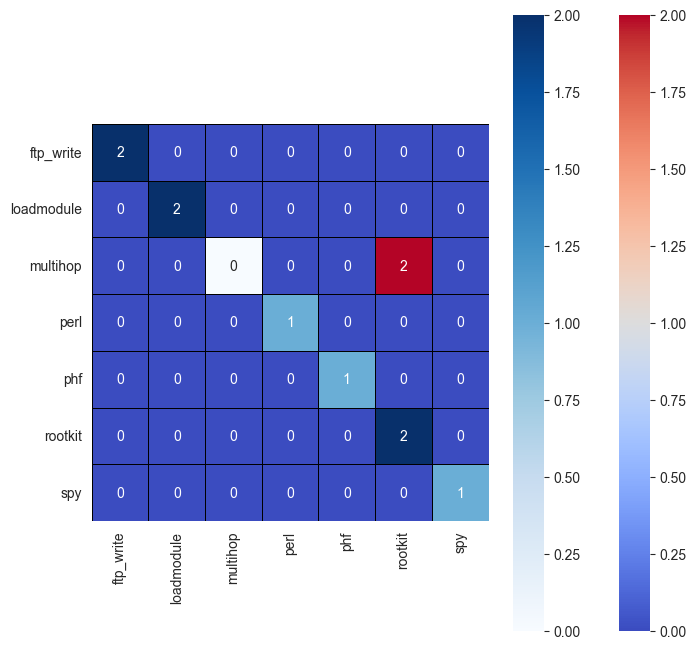

In [47]:
from sklearn.metrics import confusion_matrix

cmrf3 = confusion_matrix(y2_test_encoded, y_pred3)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmrf3.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(cmrf3, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmrf3, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2) 

In [48]:
print(classification_report(y2_test_encoded,y_pred3,target_names=target_classes2))

              precision    recall  f1-score   support

   ftp_write       1.00      1.00      1.00         2
  loadmodule       1.00      1.00      1.00         2
    multihop       0.00      0.00      0.00         2
        perl       1.00      1.00      1.00         1
         phf       1.00      1.00      1.00         1
     rootkit       0.50      1.00      0.67         2
         spy       1.00      1.00      1.00         1

    accuracy                           0.82        11
   macro avg       0.79      0.86      0.81        11
weighted avg       0.73      0.82      0.76        11



d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [49]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'n_estimators': [50,100, 150,200,300],
    'max_depth': [10, 20,30,40,50,None],
    'min_samples_split': [2, 5, 7,10],
    'max_features': ['sqrt', 'log2', None]
}


rf_model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=500, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)
random_search.fit(X2_train_smote, y2_train_smote)
random_search.best_params_

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 360 is smaller than n_iter=500. Running 360 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 50,
 'min_samples_split': 2,
 'max_features': 'log2',
 'max_depth': 10}

<Axes: >

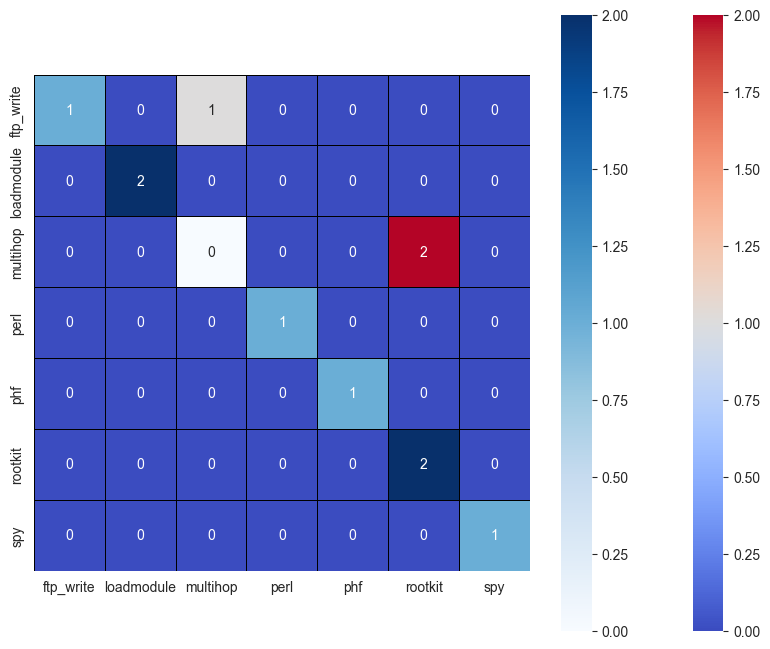

In [50]:
best_rf = random_search.best_estimator_
y_pred_rf_best = best_rf.predict(X2_test)

cmrf33 = confusion_matrix(y2_test_encoded, y_pred_rf_best)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmrf33.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmrf33, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmrf33, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2) 

In [51]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X2_train_smote,y2_train_smote)
y_pred_log_reg = logreg.predict(X2_test)

<Axes: >

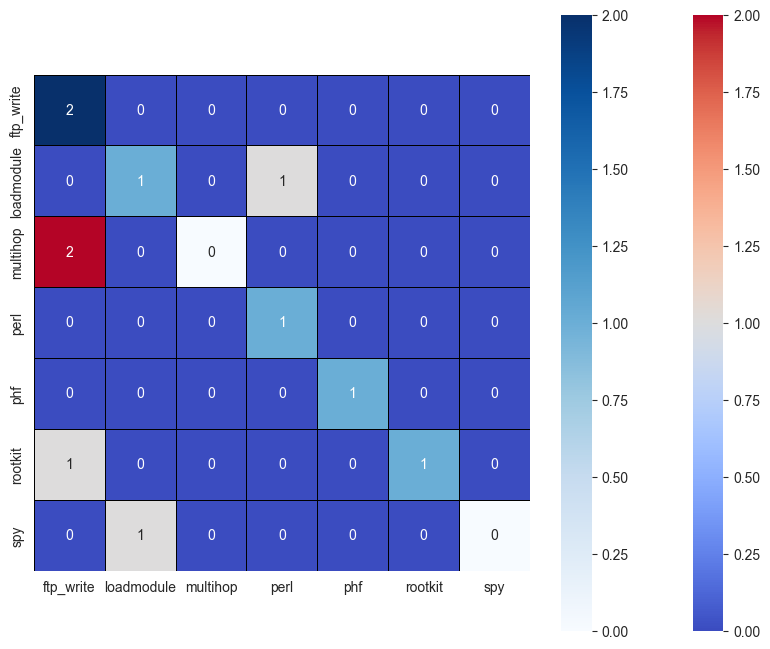

In [52]:
cmrf33 = confusion_matrix(y2_test_encoded, y_pred_log_reg)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmrf33.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmrf33, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmrf33, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2) 

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


param_dist = {
    'n_estimators': [50,100, 150,200],
    'max_depth': [3,4,5,7],
    "learning_rate": [0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb1 = XGBClassifier(objective='multi:softmax', num_class=len(target_classes2),random_state=42)

random_search = RandomizedSearchCV(xgb1, param_distributions=param_dist, 
                                   n_iter=500, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)
random_search.fit(X2_train_smote, y2_train_smote)
random_search.best_params_

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 432 is smaller than n_iter=500. Running 432 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'subsample': 0.8,
 'n_estimators': 50,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6}

<Axes: >

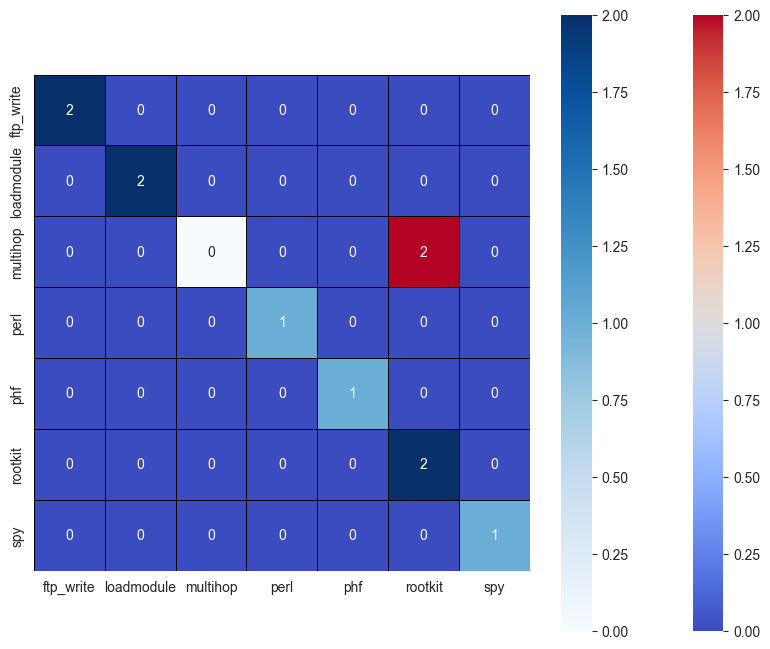

In [54]:
best_xgb = random_search.best_estimator_
y_pred_xgb_best = best_xgb.predict(X2_test)


cmbestxgb = confusion_matrix(y2_test_encoded, y_pred_xgb_best)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmbestxgb.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmbestxgb, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmbestxgb, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes2, yticklabels=target_classes2) 